# Chapter 5 – Support Vector Machines

This notebook contains all the code samples and solutions to the exercises in chapter 5 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 5. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter dives into **Support Vector Machines (SVMs)**, a powerful and versatile set of machine learning models. SVMs are capable of performing linear or nonlinear classification, regression, and even outlier detection.

Key concepts covered include:
* **Large Margin Classification:** The fundamental idea behind SVMs is to fit the "widest possible street" between classes. This is known as large margin classification.
* **Support Vectors:** The instances located on the edge of the street, which control the decision boundary. SVMs are sensitive only to these points.
* **Hard vs. Soft Margins:** Hard margin classification strictly imposes that all instances be off the street. Soft margin classification allows for some *margin violations* (instances on or on the wrong side of the street), which is more flexible and generalizes better. This is controlled by the `C` hyperparameter.
* **Nonlinear SVMs:** To handle nonlinear datasets, SVMs can use the **kernel trick**. This technique allows the model to get the same result as if it had added many polynomial features, or similarity features (like the Gaussian RBF kernel), but without the huge computational cost of actually adding them.
* **SVM Regression (SVR):** The objective is reversed: SVR tries to fit as many instances as possible *on* the street (within the margin) while limiting margin violations. The width of the street is controlled by the `epsilon` (ε) hyperparameter.
* **Under the Hood:** We briefly explore the math behind SVMs, including the decision function, the primal vs. dual problem, and how the kernel trick works mathematically.

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear SVM Classification

### Theoretical Explanation: Large Margin Classification

The core idea of an SVM is to find a decision boundary that best separates two classes. Instead of just drawing a line (or hyperplane) between them, an SVM finds the line that is as far as possible from the nearest instances of both classes. This is called **large margin classification**.

* The "street" is the area between two parallel lines that are pushed as far apart as possible while still separating the classes.
* The decision boundary is the line in the middle of this street.
* The instances that lie on the edge of the street are called **support vectors**. The SVM's decision boundary is *entirely* determined by these instances. Adding more instances *off* the street will not change the boundary at all.

### Theoretical Explanation: Soft Margin vs. Hard Margin

* **Hard Margin Classification:** This is the original idea, where we strictly impose that all instances must be *off* the street and on the correct side. This has two major drawbacks:
    1.  It only works if the data is perfectly linearly separable.
    2.  It is very sensitive to outliers.

* **Soft Margin Classification:** This is a more flexible approach that finds a balance between keeping the street as wide as possible and limiting the number of *margin violations* (instances that end up on the street or even on the wrong side).

In Scikit-Learn's SVM classes, this balance is controlled by the `C` hyperparameter:
* A **low `C`** value makes the street wider, but leads to more margin violations (more regularization).
* A **high `C`** value makes the street narrower, but leads to fewer margin violations (less regularization). If `C` is very high, the model approaches a hard margin classification.

If your SVM model is overfitting, you should try **reducing `C`**.

### Code Reproduction: LinearSVC on the Iris Dataset

The following code loads the Iris dataset, scales the features (SVMs are sensitive to feature scales), and trains a `LinearSVC` model to detect Iris-Virginica flowers.

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [3]:
# Make a prediction
svm_clf.predict([[5.5, 1.7]])

array([1.])

### Theoretical Explanation: Alternatives for Linear SVM

The `LinearSVC` class is highly optimized for linear SVMs. However, you can also use two other classes for linear classification:

1.  `SVC(kernel="linear", C=1)`: Using the `SVC` class with a linear kernel. It is much slower than `LinearSVC` but can be useful if you need to use the kernel trick (which `LinearSVC` does not support).
2.  `SGDClassifier(loss="hinge", alpha=1/(m*C))`: Using the `SGDClassifier`. It does not converge as fast as `LinearSVC` but can be useful for huge datasets that do not fit in memory (out-of-core training) or for online classification tasks.

## Nonlinear SVM Classification

### Theoretical Explanation: Handling Nonlinear Data

Many datasets are not linearly separable. One approach to handle them is to add more features, such as polynomial features. Adding these can make the dataset linearly separable.

The code below demonstrates this by creating a `PolynomialFeatures` transformer, followed by a `StandardScaler` and a `LinearSVC`.

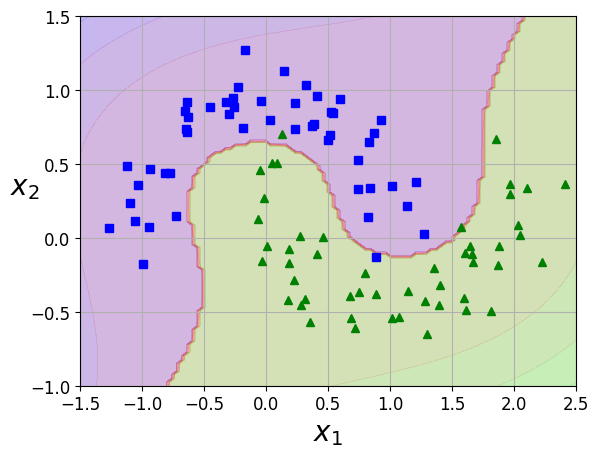

In [4]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42, max_iter=10000))
    ])

polynomial_svm_clf.fit(X, y)

# Helper function to plot the dataset and decision boundaries
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Theoretical Explanation: Polynomial Kernel

Adding polynomial features is effective, but at a high degree, it creates a huge number of features, making the model slow.

This is where the **kernel trick** comes in. It's a "miraculous mathematical technique" that makes it possible to get the same result as if you had added many polynomial features, but *without actually adding them*. This avoids the combinatorial explosion of features.

The `SVC` class implements the kernel trick. The code below trains an SVM using a 3rd-degree polynomial kernel.

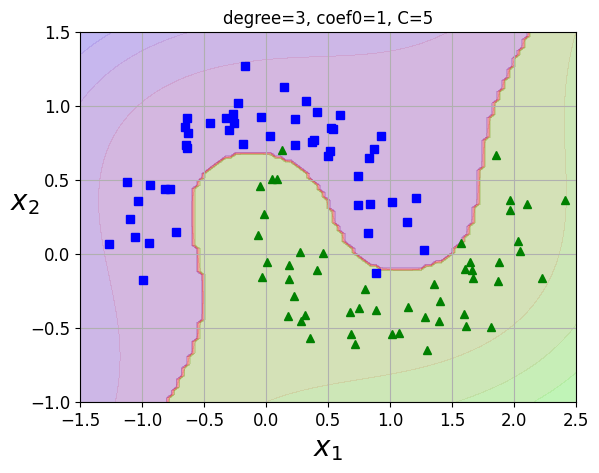

In [5]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"degree=3, coef0=1, C=5")
plt.show()

If your model is overfitting, you might want to **reduce** the polynomial degree. Conversely, if it is underfitting, you can try **increasing** it. The hyperparameter `coef0` controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

### Theoretical Explanation: Gaussian RBF Kernel

Another approach to handle nonlinear problems is to add features computed using a **similarity function**. This function measures how much each instance resembles a particular "landmark". A common similarity function is the **Gaussian Radial Basis Function (RBF)**.

Just like the polynomial features, this can be computationally expensive. But once again, the **kernel trick** works its magic: you can get a similar result as if you had added many similarity features by using the `kernel="rbf"` in the `SVC` class.

This kernel is controlled by two hyperparameters: `gamma` (γ) and `C`.
* **Increasing `gamma`** makes the bell-shaped curve narrower. This means each instance's range of influence is smaller. The decision boundary ends up being more irregular, wiggling around individual instances. A high `gamma` can lead to **overfitting**.
* **Decreasing `gamma`** makes the bell-shaped curve wider. Instances have a larger range of influence, and the decision boundary is smoother. A low `gamma` can lead to **underfitting**.

So, `gamma` acts as a regularization hyperparameter. If your model is overfitting, you should **reduce `gamma`**. If it is underfitting, you should **increase `gamma`** (similar to `C`).

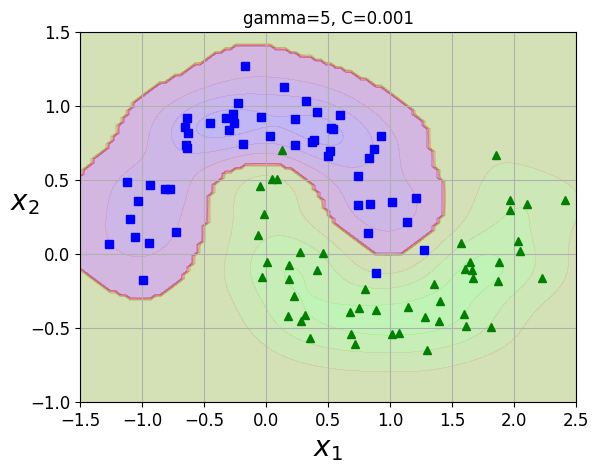

In [6]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"gamma=5, C=0.001")
plt.show()

> **Rule of thumb:** As a rule of thumb, you should always try the linear kernel first (`LinearSVC` is much faster than `SVC(kernel="linear")`). If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases.

## SVM Regression

### Theoretical Explanation: SVR

SVMs can also be used for regression. The trick is to reverse the objective: instead of trying to fit the *widest possible street between* two classes, SVM Regression (SVR) tries to fit as many instances as possible *on* the street.

The width of the street is controlled by a hyperparameter, `epsilon` (ε). The model is said to be **ε-insensitive** because adding more training instances *within* the margin does not affect the model’s predictions.

Margin violations (instances *off* the street) are penalized, and this is controlled by the `C` hyperparameter, just like in SVM classification.

In [7]:
from sklearn.svm import LinearSVR

# Generate some linear data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

### Code Reproduction: Nonlinear SVR with Kernels

To tackle nonlinear regression tasks, you can use a kernelized SVM model. The code below uses Scikit-Learn’s `SVR` class (the regression equivalent of `SVC`) with a 2nd-degree polynomial kernel.

In [8]:
from sklearn.svm import SVR

# Generate some quadratic data
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

## Under the Hood: A Theoretical Deep-Dive

This section provides the theoretical explanations required by the assignment, summarizing the mathematical concepts behind SVMs.

### Decision Function and Predictions

A linear SVM classifier predicts the class of a new instance $\mathbf{x}$ by computing the decision function $\mathbf{w}^\top \cdot \mathbf{x} + b$. If the result is positive, the predicted class $\hat{y}$ is 1 (positive class); otherwise, it is 0 (negative class).

$$\hat{y} = \begin{cases} 0 & \text{if } \mathbf{w}^\top \cdot \mathbf{x} + b < 0, \\ 1 & \text{if } \mathbf{w}^\top \cdot \mathbf{x} + b \ge 0 \end{cases}$$

The decision boundary is the set of points where the decision function is equal to 0. The margin is defined by the points where the decision function is equal to 1 or –1. Training a linear SVM means finding the values of $\mathbf{w}$ (weight vector) and $b$ (bias term) that make this margin as wide as possible while avoiding or limiting margin violations.

### Training Objective: Primal Problem

We want to minimize the norm of the weight vector, $\|\mathbf{w}\|$, to get a large margin. It is simpler to minimize $\frac{1}{2}\|\mathbf{w}\|^2 = \frac{1}{2}\mathbf{w}^\top \cdot \mathbf{w}$, which gives the same result.

**Hard Margin Objective:**
We want to find $\mathbf{w}$ and $b$ that minimize $\frac{1}{2}\mathbf{w}^\top \cdot \mathbf{w}$ subject to $t^{(i)}(\mathbf{w}^\top \cdot \mathbf{x}^{(i)} + b) \ge 1$ for all $i=1, \dots, m$.
*(Here, $t^{(i)} = -1$ for negative instances and $t^{(i)} = 1$ for positive instances)*.

**Soft Margin Objective:**
To allow for margin violations, we introduce a **slack variable** $\zeta^{(i)} \ge 0$ for each instance. $\zeta^{(i)}$ measures how much the $i$-th instance is allowed to violate the margin.
We now have two conflicting objectives: make the slack variables as small as possible (to reduce margin violations) and make $\frac{1}{2}\mathbf{w}^\top \cdot \mathbf{w}$ as small as possible (to increase the margin). The `C` hyperparameter sets the trade-off.

The objective function becomes:
Minimize $\frac{1}{2}\mathbf{w}^\top \cdot \mathbf{w} + C \sum_{i=1}^{m} \zeta^{(i)}$
Subject to $t^{(i)}(\mathbf{w}^\top \cdot \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)}$ and $\zeta^{(i)} \ge 0$ for all $i$.

### The Dual Problem

This optimization problem is a **Quadratic Programming (QP)** problem. It can be solved directly (the *primal problem*), but it is often easier and faster to solve its **dual problem**.

The dual problem is faster to solve than the primal when the number of training instances $m$ is smaller than the number of features $n$. More importantly, it makes the **kernel trick** possible, while the primal does not.

### Kernelized SVMs

The **kernel trick** is the core idea that allows SVMs to handle nonlinear datasets efficiently.

Let's say we apply a 2nd-degree polynomial transformation $\phi$ to two 2D vectors $\mathbf{a}$ and $\mathbf{b}$. The dot product of the *transformed* vectors is:

$$\phi(\mathbf{a})^\top \cdot \phi(\mathbf{b}) = (a_1^2 + \sqrt{2}a_1a_2 + a_2^2) \cdot (b_1^2 + \sqrt{2}b_1b_2 + b_2^2) = (a_1b_1 + a_2b_2)^2 = (\mathbf{a}^\top \cdot \mathbf{b})^2$$

**This is the key insight:** The dot product of the transformed vectors is equal to the square of the dot product of the original vectors.

A **kernel** is a function $K(\mathbf{a}, \mathbf{b})$ that can compute the dot product $\phi(\mathbf{a})^\top \cdot \phi(\mathbf{b})$ based only on the original vectors $\mathbf{a}$ and $\mathbf{b}$, without having to compute the transformation $\phi$ at all.

Common kernels include:
* **Linear:** $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^\top \cdot \mathbf{b}$
* **Polynomial:** $K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^\top \cdot \mathbf{b} + r)^d$
* **Gaussian RBF:** $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a} - \mathbf{b}\|^2)$
* **Sigmoid:** $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma \mathbf{a}^\top \cdot \mathbf{b} + r)$

## Exercises

From Chapter 5, page 174:

1.  What is the fundamental idea behind Support Vector Machines?
2.  What is a support vector?
3.  Why is it important to scale the inputs when using SVMs?
4.  Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?
5.  Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?
6.  Say you’ve trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease γ (gamma)? What about C?
7.  How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?
8.  Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.
9.  Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-the-rest to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?
10. Train an SVM regressor on the California housing dataset.
